In [2]:
!pip install torch

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print( torch.cuda.device_count())
    print('Available:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1
Available: Tesla T4


Installing the required libraries required

In [5]:
!pip install wget
!pip install transformers

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=3aa037ced015a05c6c6222931f4fa16db932f7f44523ab2672434989f6a319bf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Downloading the datasets

In [6]:
import wget
import os

In [7]:
url_train='https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio'
url_test='https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio'


In [8]:
wget.download(url_train)
wget.download(url_test)

'engtest.bio'

Appending all the row lines from bio format file using csvreader() function

In [9]:
import csv
sentences = []
labels = []

tokens = []
token_labels = []
unique_labels = set()

with open("./engtrain.bio", newline = '') as lines:

    line_reader = csv.reader(lines, delimiter='\t')

    for line in line_reader:

        if line == []:

            sentences.append(tokens)
            labels.append(token_labels)

            tokens = []
            token_labels = []

        else:

            tokens.append(line[1])
            token_labels.append(line[0])

            unique_labels.add(line[0])


Sentences output

In [10]:
[  print(' '.join(sentences[i])) for i in range(10)]

what movies star bruce willis
show me films with drew barrymore from the 1980s
what movies starred both al pacino and robert deniro
find me all of the movies that starred harold ramis and bill murray
find me a movie with a quote about baseball in it
what movies have mississippi in the title
show me science fiction films directed by steven spielberg
do you have any thrillers directed by sofia coppola
what leonard cohen songs have been used in a movie
show me films elvis films set in hawaii


[None, None, None, None, None, None, None, None, None, None]

Sample input sentence

In [11]:
' '.join(sentences[1])

'show me films with drew barrymore from the 1980s'

In [12]:
pd.DataFrame({"Word":sentences[1],"Labels":labels[1]})

,Word,Labels
0,show,O
1,me,O
2,films,O
3,with,O
4,drew,B-ACTOR
5,barrymore,I-ACTOR
6,from,O
7,the,O
8,1980s,B-YEAR


In [13]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 9,775


Preparing input text data for Feeding it into BERT model by converting and spilting the text into tokens and mapping the tokens using BertTokenizer functon

In [14]:
from transformers import BertTokenizer
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
tokenizer.encode(sentences[1])

[101, 2265, 2033, 3152, 2007, 3881, 100, 2013, 1996, 3865, 102]

In [16]:
tokenizer.decode([101, 2265, 2033, 3152, 2007, 3881, 100, 2013, 1996, 3865, 102])

'[CLS] show me films with drew [UNK] from the 1980s [SEP]'


Calculating of length of each tokenized sentences

In [17]:
TokenLength=[len(tokenizer.encode(' '.join(i),add_special_tokens=True))for i in sentences]

In [18]:
print('Minimum  length: {:,} tokens'.format(min(TokenLength)))
print('Maximum length: {:,} tokens'.format(max(TokenLength)))
print('Median length: {:,} tokens'.format(int(np.median(TokenLength))))

Minimum  length: 3 tokens
Maximum length: 51 tokens
Median length: 12 tokens


<ipython-input-19-4b39a5f15c7a>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(TokenLength, kde=False, rug=False,color='plum')


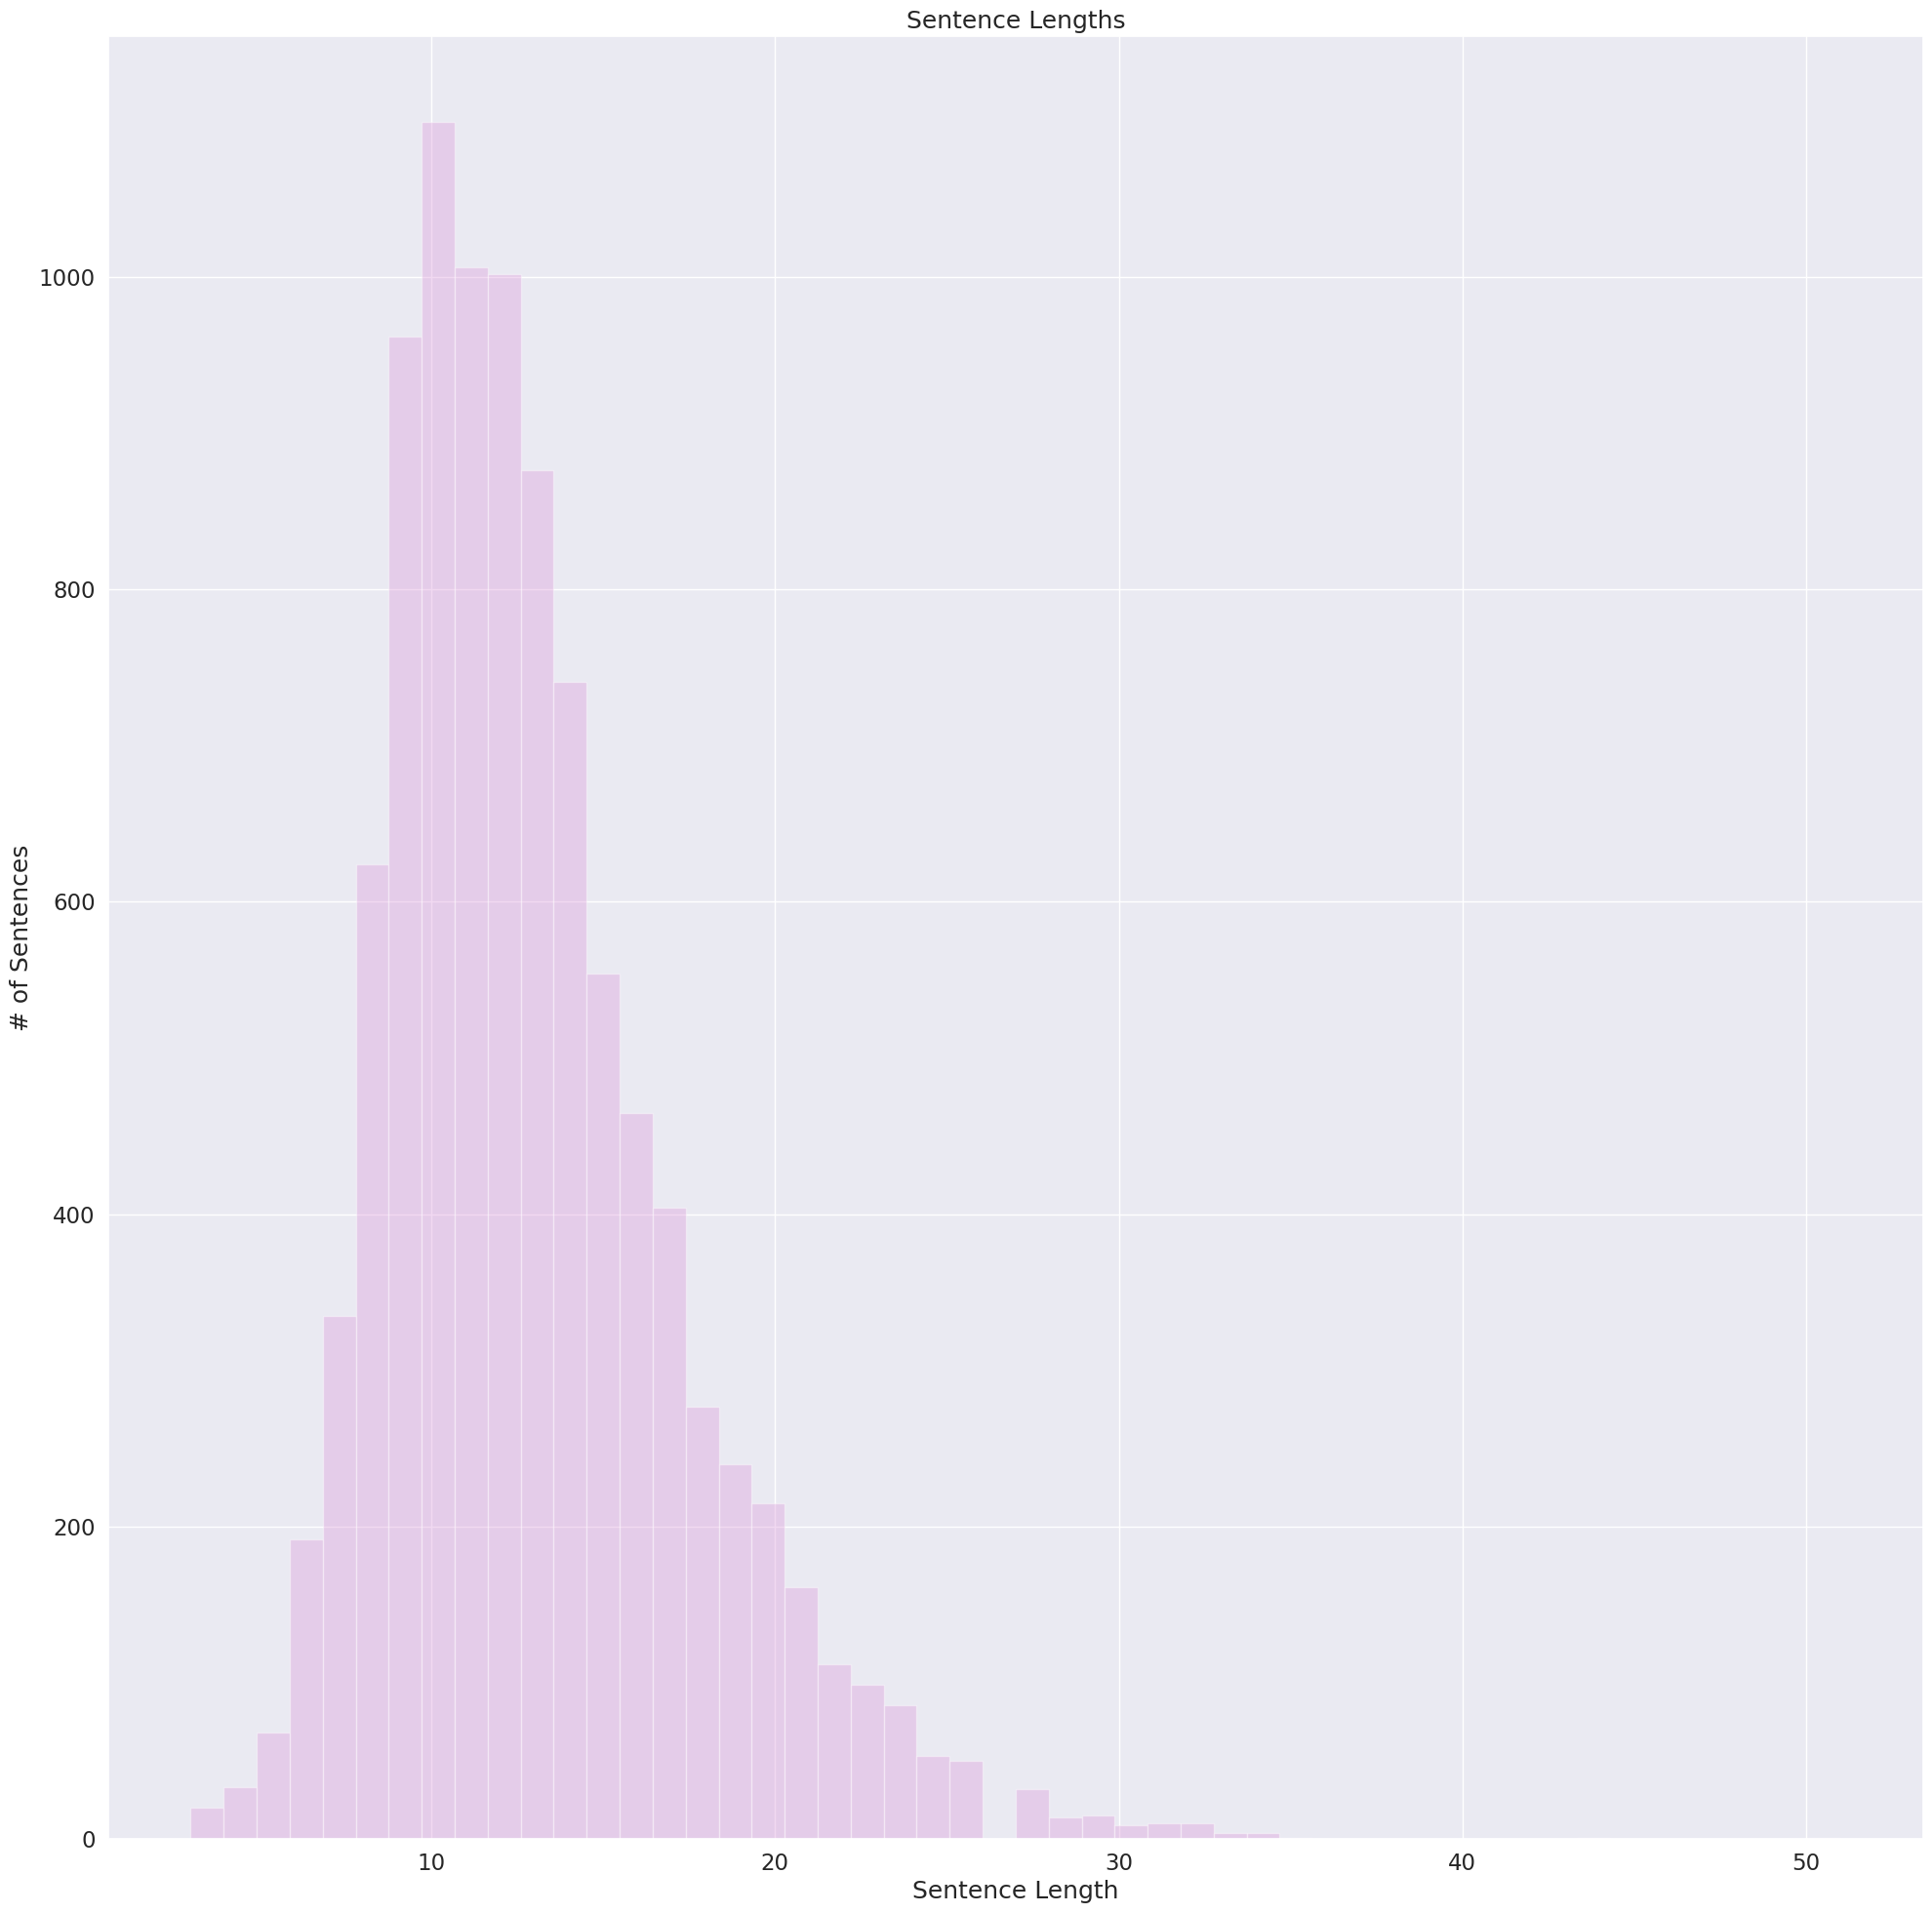

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24,24))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(TokenLength, kde=False, rug=False,color='plum')

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences');

Now we must include Padding [PAD] token in the input so every tokens should be of same length. I have selected max length of PAD token to be 55

In [20]:
SampleSentence=tokenizer.encode_plus(' '.join(sentences[1]), add_special_tokens = True,truncation = True,max_length = 50,padding = True,return_attention_mask = True, return_tensors = 'pt')
SampleSentence

{'input_ids': tensor([[ 101, 2265, 2033, 3152, 2007, 3881, 6287, 5974, 2013, 1996, 3865,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [21]:
##input_ids
print("\nInput Ids:",SampleSentence["input_ids"])
##attention_mask
print("\nAttention Mask:",SampleSentence["attention_mask"])


Input Ids: tensor([[ 101, 2265, 2033, 3152, 2007, 3881, 6287, 5974, 2013, 1996, 3865,  102]])

Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


Mapping Label

In [22]:
label_map = {}

for (i, label) in enumerate(unique_labels):

    # Map it to its integer
    label_map[label] = i

Adding Attention Mask

In [23]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 55,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )


    input_ids.append(encoded_dict['input_ids'][0])

    # And its attention mask
    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[10])
print('Token IDs:', input_ids[10])
print('Masks:', attention_masks[10])

Original:  ['what', 'movie', 'is', 'references', 'zydrate']
Token IDs: tensor([  101,  2054,  3185,  2003,  7604,  1062, 25688, 11657,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


In [24]:
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):

    padded_labels = []

    orig_labels_i = 0

    for token_id in sen:

        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):

            padded_labels.append(null_label_id)

        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            padded_labels.append(null_label_id)

        else:

            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))

    new_labels.append(padded_labels)

In [25]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])


Sentence:     ['what', 'movies', 'starred', 'both', 'al', 'pacino', 'and', 'robert', 'deniro']

Labels:       ['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['what', 'movies', 'starred', 'both', 'al', 'pac', '##ino', 'and', 'robert', 'den', '##iro']

Token IDs:    tensor([  101,  2054,  5691,  5652,  2119,  2632, 14397,  5740,  1998,  2728,
         7939,  9711,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])

New Labels:   [-100, 1, 1, 1, 1, 7, 9, -100, 1, 7, 9, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

Convert the lists into PyTorch tensors using torch.stack

In [26]:
pt_input_ids = torch.stack(input_ids, dim=0)

pt_attention_masks = torch.stack(attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [27]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,797 training samples
  978 validation samples


Convert tensors into Batches for batch wise training and using RandomSampler for selecting the batch Randomly

In [32]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )

validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size   )


Using 12 Layer BERT Model for out task

In [33]:
from transformers import BertForTokenClassification, AdamW, BertConfig


model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(label_map) + 1, output_attentions = False, output_hidden_states = False)


model.cuda()


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [34]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [35]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [36]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [37]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.42
======== Epoch 2 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.17
======== Epoch 3 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.13
======== Epoch 4 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.09


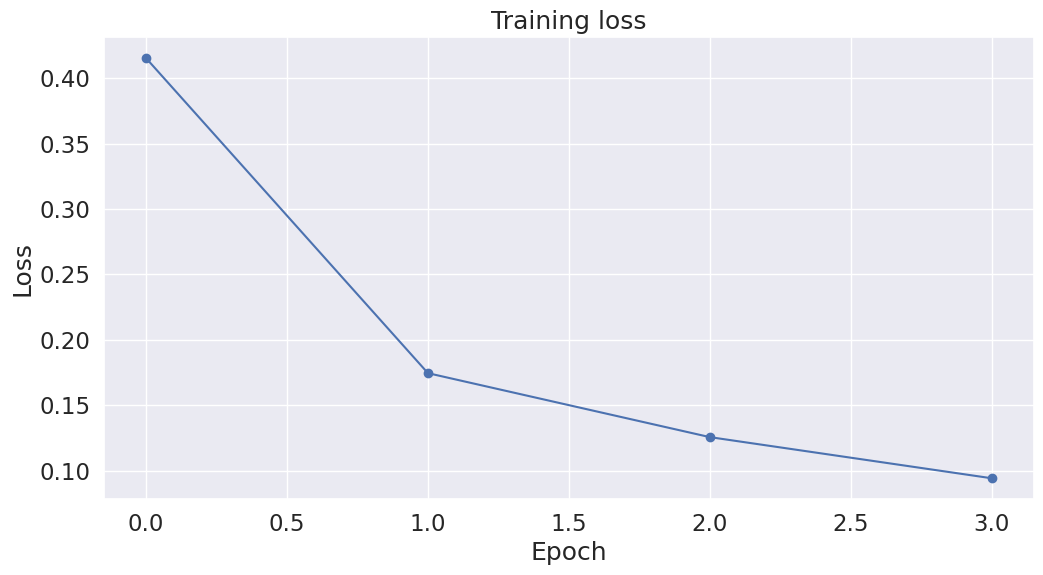

In [38]:
import seaborn as sns

sns.set(style='darkgrid')


sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Preparing the Test dataset same as training dataset for predicting the results of our Trained model

In [39]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []
unique_labels = set()

with open("./engtest.bio", newline = '') as lines:

    line_reader = csv.reader(lines, delimiter='\t')

    for line in line_reader:

        if line == []:

            sentences.append(tokens)
            labels.append(token_labels)

            tokens = []
            token_labels = []

        else:

            tokens.append(line[1])
            token_labels.append(line[0])
            unique_labels.add(line[0])

In [40]:
input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)

    encoded_dict = tokenizer.encode_plus(sent_str,add_special_tokens = True, max_length = 50,pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')

    input_ids.append(encoded_dict['input_ids'][0])

    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  ['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now']
Token IDs: tensor([  101,  2024,  2045,  2151,  2204,  6298, 22092,  2041,  2157,  2085,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [41]:
new_labels = []

null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):

    padded_labels = []

    orig_labels_i = 0

    for token_id in sen:

        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):

            padded_labels.append(null_label_id)

        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            padded_labels.append(null_label_id)

        else:


            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))

    new_labels.append(padded_labels)

In [42]:
print('\nSentence:    ', sentences[0])
print('\nLabels:      ', labels[0])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[0])))
print('\nToken IDs:   ', input_ids[0])
print('\nMask:        ', attention_masks[0])
print('\nNew Labels:  ', new_labels[0])


Sentence:     ['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now']

Labels:       ['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'B-YEAR', 'I-YEAR']

BERT Tokens:  ['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now']

Token IDs:    tensor([  101,  2024,  2045,  2151,  2204,  6298, 22092,  2041,  2157,  2085,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

New Labels:   [-100, 1, 1, 1, 1, 12, 18, 1, 14, 23, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

In [43]:
pt_input_ids = torch.stack(input_ids, dim=0)

pt_attention_masks = torch.stack(attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [44]:
batch_size = 32

prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Prediction on test set

In [45]:
print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,443 test sentences...
    DONE.


In [46]:
from sklearn.metrics import f1_score

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels.

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape)


# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)

After flattening the batches, the predictions have shape:
     (2443, 50, 26)

After choosing the highest scoring label for each token:
     (2443, 50)

After flattening the sentences, we have predictions:
     (122150,)
and ground truth:
     (122150,)


In [47]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:

        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))

Before filtering out `null` tokens, length = 122,150
 After filtering out `null` tokens, length = 24,686


In [48]:
from sklearn.metrics import f1_score

f1 = f1_score(real_token_labels, real_token_predictions, average='micro')

print ("F1 score: {:.2%}".format(f1))

F1 score: 94.39%


Testing and checking the trained model

In [49]:
test_sentence = "Characterized by its use of Technicolor, fantasy storytelling, musical score, and memorable characters, the film has become an American pop culture icon. It was nominated for six Academy Awards, including Best Picture, but lost to Gone with the Wind, also directed by Fleming."

In [50]:
#Encoding and convert the sentences into tensors
sample_sentence = tokenizer.encode(test_sentence)
sample_input_ids = torch.tensor([sample_sentence]).cuda()

#Predicting the test data set using model() function
with torch.no_grad():
    output = model(sample_input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

#Function which retrieves key value for our Label Dictionary
def get_key(val):
    for key, value in label_map.items():
         if val == value:
             return key

    return "key doesn't exist"

#Tokenize
tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])
new_tokens, new_label = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_label.append(get_key(label_idx))
        new_tokens.append(token)

#Appending Tokens and Labels
movie_token=[]
movie_label=[]
for token, label in zip(new_tokens, new_label):
    movie_token.append(token)
    movie_label.append(label)

df=pd.DataFrame({"Token":movie_token,"Movie_Label":movie_label})
df.T

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
Token,[CLS],characterized,by,its,use,of,technicolor,",",fantasy,storytelling,...,with,the,wind,",",also,directed,by,fleming,.,[SEP]
Movie_Label,O,O,O,O,O,O,O,O,B-GENRE,O,...,I-TITLE,I-TITLE,I-TITLE,O,O,O,O,I-DIRECTOR,O,O


In [51]:
import joblib
filename = 'final_model.h5'
joblib.dump(model, filename)

['final_model.h5']